# Order Volume Forecasting

## Objective

The primary goal of this project was to build a state-of-the-art time series forecasting system that accurately predicts key business metrics, enabling Olist to anticipate future trends and support critical business decisions. This mission includes:
1. **Accurately forecasting order volumes**, which optimizes inventory and resource management, minimizing stockouts and overstocking.
2. **Forecasting revenue trends**, which provides a clear financial roadmap and supports strategic planning and long-term growth.

This notebook focuses on **forecasting order volumes**. To achieve this, I preprocess the dataset to ensure data quality and readiness for effective model development and evaluation. The insights generated serve as a foundation for actionable recommendations to drive business success.

## Dataset Description

It was powered by Olist's real transaction data, comprising over 100,000 orders across Brazil's diverse regions, collected from [Kaggle](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce/data).

**olist_orders_dataset.csv:**

| No. | Column Name | Description |
|---|-------------|-------------|
| 1 | order_id | Unique identifier for each order. |
| 2 | customer_id | Unique identifier for the customer who placed the order. |
| 3 | order_status | Current status of the order (e.g., `delivered`, `shipped`, `canceled`, etc.). |
| 4 | order_purchase_timestamp | Timestamp when the order was placed by the customer. |
| 5 | order_approved_at | Timestamp when payment for the order was approved. |
| 6 | order_delivered_carrier_date | Timestamp when the order was handed to the logistics partner for delivery. |
| 7 | order_delivered_customer_date | Timestamp when the order was delivered to the customer. |
| 8 | order_estimated_delivery_date | Estimated delivery date provided at the time of purchase. |

# Importing Library

In [1]:
import pytz
import joblib
import itertools
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from calendar import month_name
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

# Loading Data and Exploration

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load the dataset
base_path = '/content/drive/MyDrive/dibimbing.id/Day44 - Final Project Data Science/Project/'
orders = pd.read_csv(base_path + 'dataset/olist_orders_dataset.csv')

In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [5]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [6]:
# Convert to datetime type
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

# Filter only for delivered status
orders = orders[orders['order_status'] == 'delivered']

# Create daily time series
daily_orders = (
    orders.set_index('order_purchase_timestamp')
    .resample('D')
    .size()
    .reset_index(name='total_orders')
    .rename(columns={'order_purchase_timestamp': 'ds'})
)

## Remove Anomalous Dates

**Monthly anomaly**

In [7]:
# Create monthly time series
monthly_orders = (
    orders.set_index('order_purchase_timestamp')
    .resample('M')
    .size()
    .reset_index(name='total_orders')
    .rename(columns={'order_purchase_timestamp': 'ds'})
)
monthly_orders

,ds,total_orders
0,2016-09-30,1
1,2016-10-31,265
2,2016-11-30,0
3,2016-12-31,1
4,2017-01-31,750
5,2017-02-28,1653
6,2017-03-31,2546
7,2017-04-30,2303
8,2017-05-31,3546
9,2017-06-30,3135


Based on the above results, the daily order volume in 2016 was significantly lower compared to the monthly order volumes in 2017 and 2018. This discrepancy could have negatively impacted the accuracy of the time series forecasting model and was likely caused by data errors. Therefore, I decided to drop the 2016 data to improve model performance.

In [8]:
# I only chose dates between 2017-01 and 2018-08
daily_orders = daily_orders[
    (daily_orders['ds'] >= '2017-01-01') &
    (daily_orders['ds'] <= '2018-08-31')
]

**Daily anomaly**

In [9]:
daily_orders.head(20)

,ds,total_orders
108,2017-01-01,0
109,2017-01-02,0
110,2017-01-03,0
111,2017-01-04,0
112,2017-01-05,32
113,2017-01-06,4
114,2017-01-07,4
115,2017-01-08,4
116,2017-01-09,5
117,2017-01-10,6


In [10]:
daily_orders.tail(20)

,ds,total_orders
694,2018-08-10,249
695,2018-08-11,185
696,2018-08-12,191
697,2018-08-13,284
698,2018-08-14,311
699,2018-08-15,282
700,2018-08-16,316
701,2018-08-17,249
702,2018-08-18,193
703,2018-08-19,204


From the results above, it appears that there are incomplete orders for the dates between 2018-08-24 and 2018-08-29. This is likely because these orders had not yet reached the "delivered" status. Therefore, I excluded these dates to ensure an accurate analysis.

In [11]:
# List of dates to exclude
exclude_dates = ['2018-08-24', '2018-08-25', '2018-08-26',
                 '2018-08-27', '2018-08-28', '2018-08-29']

# Convert exclude_dates to datetime format
exclude_dates = pd.to_datetime(exclude_dates)

# Exclude the dates from daily_orders
daily_orders = daily_orders[~daily_orders['ds'].isin(exclude_dates)]

In [12]:
# Create complete date range covering the data
full_date_range = pd.date_range(
    start=daily_orders['ds'].min(),
    end=daily_orders['ds'].max(),
    freq='D'  # 'D' for daily frequency
)

In [13]:
# Find missing dates
missing_dates = full_date_range.difference(daily_orders['ds'])
print(f"Missing dates: {missing_dates}")
print(f"Number of missing dates: {len(missing_dates)}")

Missing dates: DatetimeIndex([], dtype='datetime64[ns]', freq='D')
Number of missing dates: 0


In [14]:
# Renaming the column
daily_orders.columns = ['ds', 'y']

# Reset the index
daily_orders = daily_orders.reset_index(drop=True)

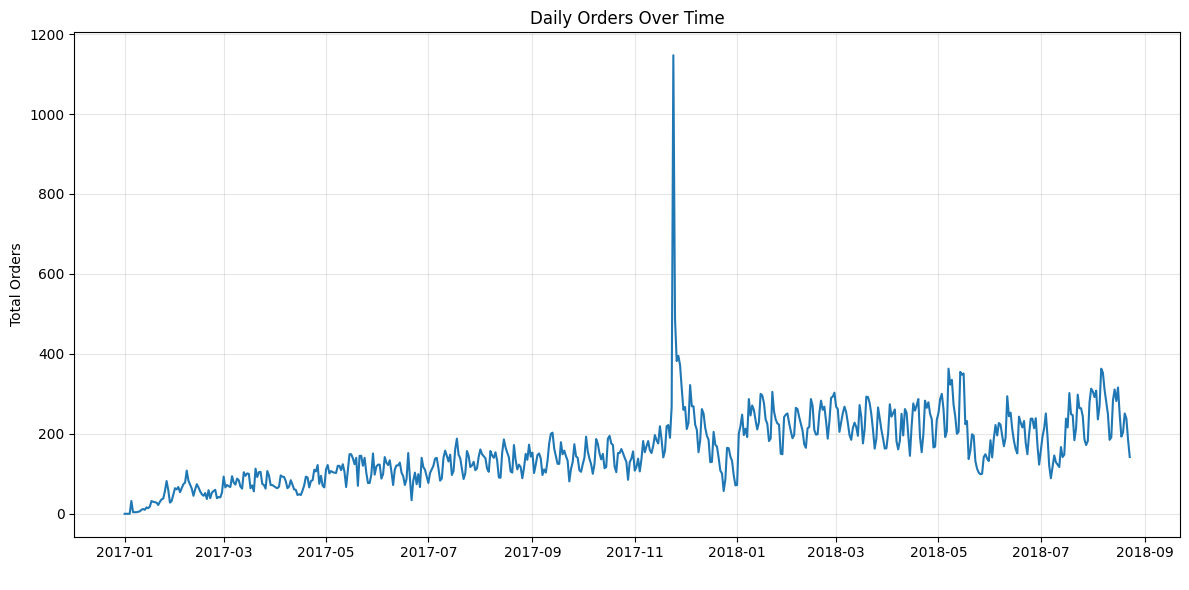

In [15]:
# Create a daily orders over time graph
plt.figure(figsize=(12, 6))
plt.plot(daily_orders['ds'], daily_orders['y'], linestyle='-')

# Formatting
plt.title('Daily Orders Over Time')
plt.xlabel(' ')
plt.ylabel('Total Orders')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

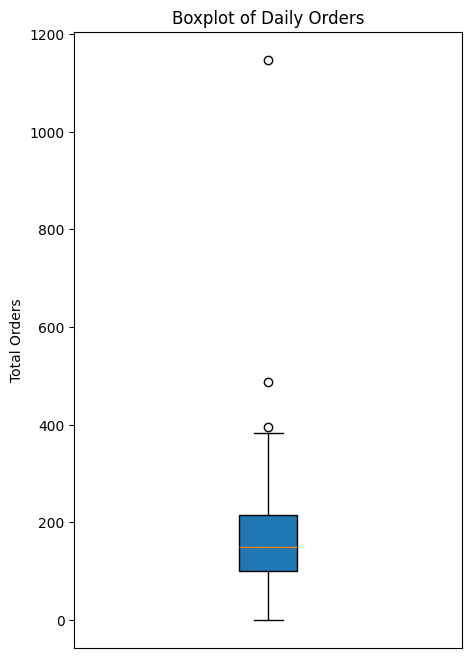

In [16]:
# Creating the boxplot
plt.figure(figsize=(5, 8))
plt.boxplot(daily_orders['y'], vert=True, patch_artist=True)
plt.title('Boxplot of Daily Orders')
plt.ylabel('Total Orders')
plt.xticks([])
plt.show()

In [17]:
daily_orders[daily_orders['y'] > 390].sort_values(by='y', ascending=False)

,ds,y
327,2017-11-24,1147
328,2017-11-25,487
330,2017-11-27,395


From the charts and the table above, it appears that daily orders increase over time, with significant outliers observed during the Black Friday event (2017-11-24). I decided not to remove these outliers because the SARIMA model can account for them as exogenous variables.

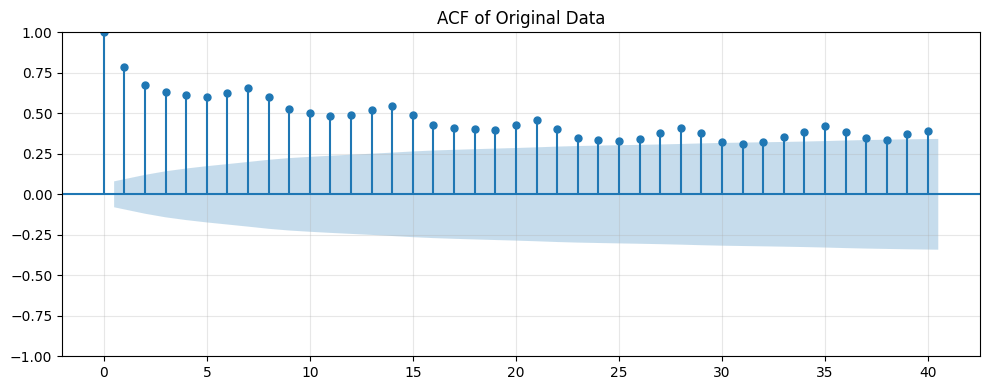

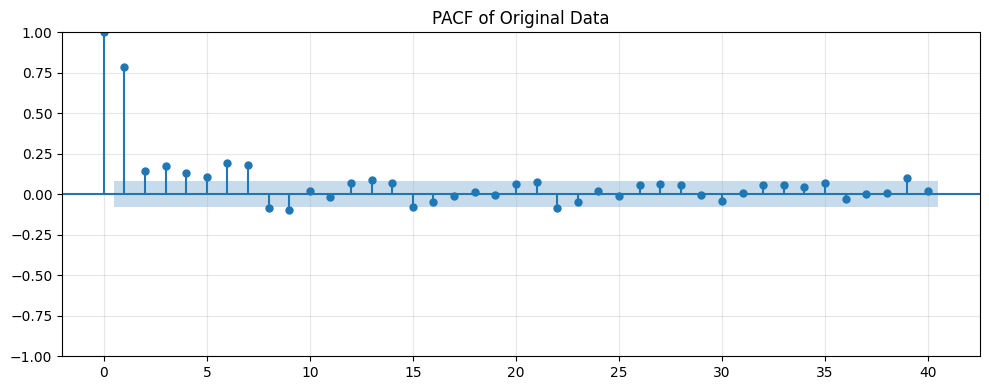

In [18]:
# ACF Plot with controlled figure size
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(daily_orders['y'], lags=40, alpha=0.05, title='ACF of Original Data', ax=ax)
plt.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()

# PACF Plot with controlled figure size
fig, ax = plt.subplots(figsize=(10, 4))
plot_pacf(daily_orders['y'], lags=40, alpha=0.05, title='PACF of Original Data', ax=ax)
plt.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()

The ACF plot was used to determine the MA (Moving Average) part, or q term, of the SARIMA model, while the PACF plot was used to determine the AR (Autoregression) part, or p term, of the SARIMA model.

From the ACF and PACF plots above, it appears that the dataset exhibits weekly seasonality, as indicated by significant lags at multiples of 7, and possibly yearly seasonality (which will be further explored in another section).

The model diagnostics or residual analysis should address this effect by capturing the pattern, reducing significant lags near zero, or ensuring they fall within the confidence interval (blue-shaded region).

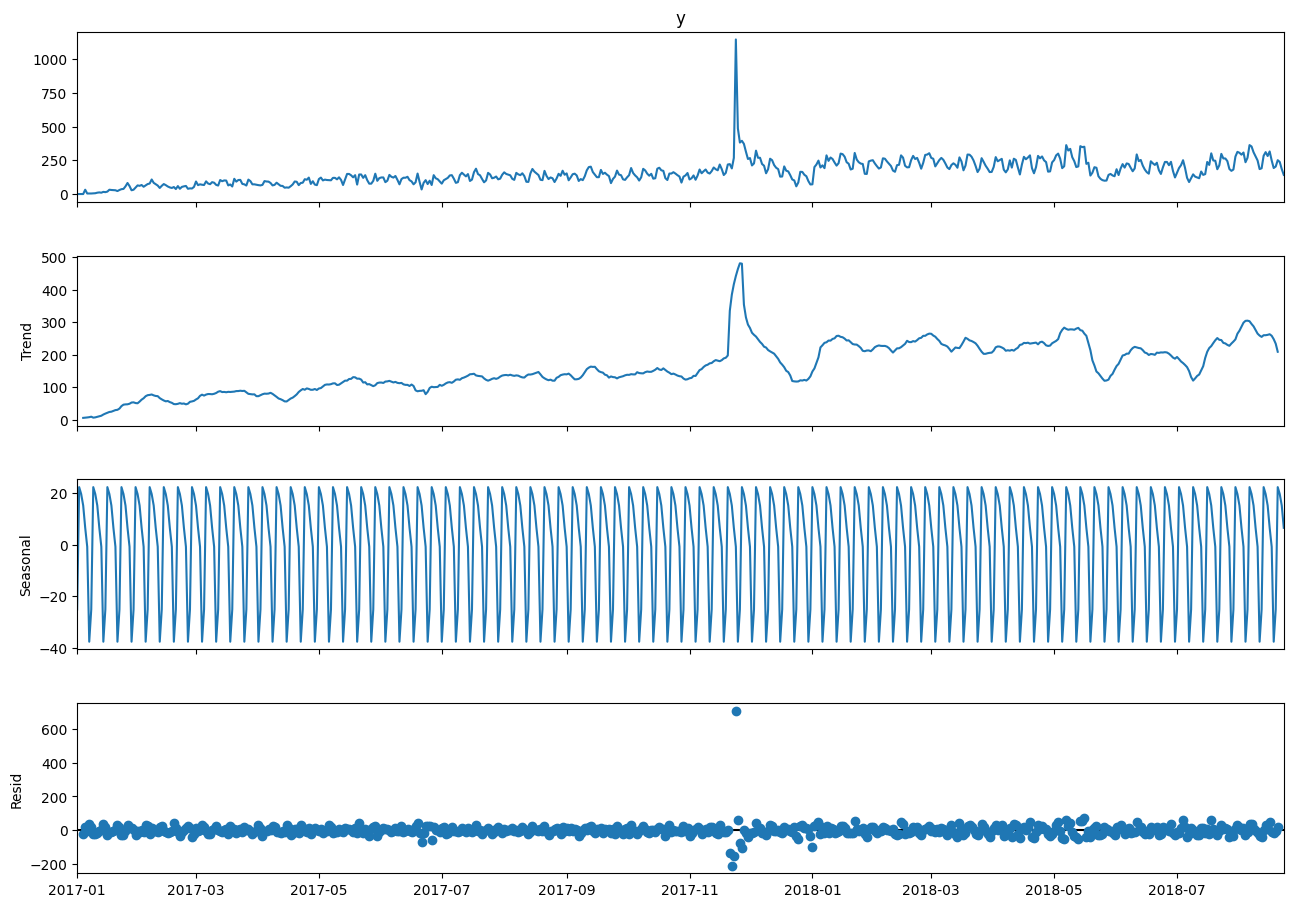

In [19]:
# Seasonal Decompose
daily_decompose = daily_orders.set_index('ds')
daily_decompose = daily_decompose.asfreq('D')

decomposition = seasonal_decompose(daily_decompose['y'], model='additive')
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

From the graph above, the trend increased over time and showed apparent weekly seasonality. The residuals highlighted the effect of outliers, such as those during Black Friday.

# Stationary Test

In [20]:
# Non-seasonal ADF test on original data
def adf_test(series, title=''):
    print(f'\nADF Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')  # Drop NA for test
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for k, v in result[4].items():
        print(f'   {k}: {v}')
    print(f'Result: {"Stationary" if result[1] < 0.05 else "Non-Stationary"}')

In [21]:
adf_test(daily_orders['y'], title='Original Data (Non-Seasonal)')


ADF Test: Original Data (Non-Seasonal)
ADF Statistic: -2.8962552166998132
p-value: 0.045785201013924595
Critical Values:
   1%: -3.4415777369651717
   5%: -2.866493255736561
   10%: -2.569407951640003
Result: Stationary


In [22]:
decomposition = seasonal_decompose(daily_orders.set_index('ds')['y'], period=7)  # period=S=7
residuals = decomposition.resid.dropna()

In [23]:
# Seasonal ADF test on residuals
adf_test(residuals, title='Residuals After Seasonal Decomposition (Seasonal)')


ADF Test: Residuals After Seasonal Decomposition (Seasonal)
ADF Statistic: -9.933342490550544
p-value: 2.785175742317515e-17
Critical Values:
   1%: -3.4417938762914972
   5%: -2.866588428280353
   10%: -2.5694586650317475
Result: Stationary


The stationarity test using the ADF shows that the dataset is non-stationary, as indicated by the p-value < 0.05. However, this p-value (0.0457) for non-seasonal is close to the threshold, suggesting a borderline non-stationary behavior. Therefore, I attempted differencing to see if it improves the model's performance.

# Save the CSV Files for Deployment

In [24]:
# Save the last 30 days for creating synthetic dataset
order_to_save = daily_orders.iloc[:-30].copy()
order_to_save.rename(columns={'ds': 'date', 'y': 'order_volume'}, inplace=True)

In [25]:
# Rename the column
last_30_days = daily_orders.iloc[-30:].copy()
last_30_days.rename(columns={'ds': 'date', 'y': 'order_volume'}, inplace=True)

In [26]:
# Save DataFrame to CSV
save_csv_path = base_path
save_csv_path = Path(save_csv_path) / 'saved_csv'
save_csv_path.mkdir(parents=True, exist_ok=True)  # Create dir if missing

order_to_save.to_csv(save_csv_path / "order_volume.csv", index=False)
last_30_days.to_csv(save_csv_path / "order_volume_last_30_days.csv", index=False)

In [27]:
# print(last_30_days['order_volume'].to_string(index=False))

# Creating New Features

Creating new features representing the dates around the Black Friday event as exogenous variables in the SARIMA model.

In [28]:
def create_features(df):
    df = df.copy()

    # Generate Black Friday dates dynamically (fourth Friday of November)
    df['year'] = df['ds'].dt.year
    df['black_friday'] = df.apply(lambda row: pd.date_range(start=f'{row.year}-11-01', end=f'{row.year}-11-30', freq='WOM-4FRI')[0], axis=1)
    # ---- BLACK FRIDAY ----
    df['is_black_friday'] = (df['ds'].isin(['2017-11-24','2017-11-25'])).astype(int) # significant
    df['is_black_friday_peak'] = (df['ds'] == df['black_friday']).astype(int)  # significant. Black friday: 2017-11-24, ...
    df.drop(columns=['black_friday', 'year'], inplace=True)

    return df

# Train-Test Split

In [29]:
forecast_days = 30
split_date = daily_orders['ds'].max() - pd.Timedelta(days=forecast_days)
train = daily_orders[daily_orders['ds'] <= split_date].copy()
test = daily_orders[daily_orders['ds'] > split_date].copy()

# Print min and max dates
print("Train date range:", train['ds'].min(), "to", train['ds'].max())
print("Test date range:", test['ds'].min(), "to", test['ds'].max())

Train date range: 2017-01-01 00:00:00 to 2018-07-24 00:00:00
Test date range: 2018-07-25 00:00:00 to 2018-08-23 00:00:00


In [30]:
train = create_features(train)
test = create_features(test)

# Add features to daily_orders (for full-dataset retraining)
daily_orders = create_features(daily_orders.copy())

In [31]:
# Regressor Features
regressor_features = ['is_black_friday','is_black_friday_peak']

# Yeo-Johnson Transformation

In [32]:
# Initialize transformer
pt = PowerTransformer(method='yeo-johnson')

In [33]:
# Only fit to train set and transform to test and daily_orders (avoiding data leakage)
train['y_transformed'] = pt.fit_transform(train[['y']]).flatten()
test['y_transformed'] = pt.transform(test[['y']]).flatten()
daily_orders['y_transformed'] = pt.transform(daily_orders[['y']]).flatten()

In [34]:
# Keep original 'y' (unchanged)
train['y_original'] = train['y']
test['y_original'] = test['y']
daily_orders['y_original'] = daily_orders['y']

# Hyperparameter Tuning using SARIMA

In [35]:
print("Performing SARIMA tuning...")

# Define individual parameter ranges
p_range = range(0, 2)      # AR order
d_range = [1]              # Differencing order
q_range = range(0, 2)      # MA order

P_range = range(0, 2)      # Seasonal AR order
D_range = [0]              # Seasonal differencing order
Q_range = range(0, 2)      # Seasonal MA order
S_range = [7]              # Seasonal period (weekly in this case)

# Create all combinations of non-seasonal parameters
pdq = list(itertools.product(p_range, d_range, q_range))

# Create all combinations of seasonal parameters
seasonal_pdq = list(itertools.product(P_range, D_range, Q_range, S_range))

# Count combinations
print(f"Non-seasonal combinations: {len(pdq)}")
print(f"Seasonal combinations: {len(seasonal_pdq)}")
print(f"Total combinations: {len(pdq) * len(seasonal_pdq)}")

Performing SARIMA tuning...
Non-seasonal combinations: 4
Seasonal combinations: 4
Total combinations: 16


In [36]:
best_aic = np.inf
best_params = None
best_seasonal_params = None

# Prepare aligned endogenous and exogenous variables
endog = train['y_transformed'].reset_index(drop=True)
exog = train[regressor_features].reset_index(drop=True)

# Grid search
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(endog,
                          exog=exog,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=True,
                          enforce_invertibility=True,
                          initialization='approximate_diffuse'
                          )
            results = mod.fit(disp=False)

            if results.aic < best_aic:
                best_aic = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
                # best_params = (1,1,1)
                # best_seasonal_params = (1,0,1,7)

            print(f"ARIMA{param}x{param_seasonal} - AIC:{results.aic:.2f}")
        except:
            continue

print(f"\nBest SARIMA params: {best_params}x{best_seasonal_params} - AIC: {best_aic:.2f}")

ARIMA(0, 1, 0)x(0, 0, 0, 7) - AIC:601.42
ARIMA(0, 1, 0)x(0, 0, 1, 7) - AIC:603.13
ARIMA(0, 1, 0)x(1, 0, 0, 7) - AIC:550.83
ARIMA(0, 1, 0)x(1, 0, 1, 7) - AIC:447.03
ARIMA(0, 1, 1)x(0, 0, 0, 7) - AIC:614.06
ARIMA(0, 1, 1)x(0, 0, 1, 7) - AIC:602.70
ARIMA(0, 1, 1)x(1, 0, 0, 7) - AIC:514.12
ARIMA(0, 1, 1)x(1, 0, 1, 7) - AIC:398.17
ARIMA(1, 1, 0)x(0, 0, 0, 7) - AIC:603.42
ARIMA(1, 1, 0)x(0, 0, 1, 7) - AIC:594.83
ARIMA(1, 1, 0)x(1, 0, 0, 7) - AIC:541.15
ARIMA(1, 1, 0)x(1, 0, 1, 7) - AIC:413.93
ARIMA(1, 1, 1)x(0, 0, 0, 7) - AIC:546.16
ARIMA(1, 1, 1)x(0, 0, 1, 7) - AIC:539.62
ARIMA(1, 1, 1)x(1, 0, 0, 7) - AIC:518.19
ARIMA(1, 1, 1)x(1, 0, 1, 7) - AIC:394.53

Best SARIMA params: (1, 1, 1)x(1, 0, 1, 7) - AIC: 394.53


# Train the model using SARIMA

Since the SARIMA model performed poorly at the beginning of the periods due to the lack of prior sequence data, I burned in the first 10 periods to prevent bias and maintain model performance.

In [37]:
# Calculate burn-in period
p, d, q = best_params
P, D, Q, S = best_seasonal_params
burn_in = 10
print(f"Burn-in period: {burn_in} days")

Burn-in period: 10 days


In [38]:
# Train final SARIMA model
print("Training final SARIMA model...")

# Prepare aligned endogenous and exogenous variables
endog = train['y_transformed'].reset_index(drop=True)
exog = train[regressor_features].reset_index(drop=True)

final_sarima = SARIMAX(endog,
                       exog=exog,
                       order=best_params,
                       seasonal_order=best_seasonal_params,
                       enforce_stationarity=True,
                       enforce_invertibility=True,
                       initialization='approximate_diffuse'
                       )
sarima_results = final_sarima.fit(disp=False)

Training final SARIMA model...


## Save the Model for Deployment

Save the model for evaluating metrics during deployment.

In [39]:
save_model_path = base_path
saved_models_dir = Path(save_model_path) / 'saved_models'
saved_models_dir.mkdir(parents=True, exist_ok=True)  # Create dir if missing

# Get current time in GMT+7 (Asia/Bangkok, Asia/Jakarta, etc.)
tz = pytz.timezone('Asia/Bangkok')
current_time = datetime.now(tz)

version = current_time.strftime("%Y%m%d_%H%M")
deploy_model_path = saved_models_dir / f'order_volume_sarima_eval_v{version}.joblib'

# Save both SARIMA model and PowerTransformer
deploy_artifact = {
    'model': sarima_results,
    'transformer': pt
}

# Save the model
joblib.dump(deploy_artifact, deploy_model_path)

print(f"✅ Model will be saved to: {deploy_model_path}")
print(f"Time used: {current_time} (GMT+7)")

✅ Model will be saved to: /content/drive/MyDrive/dibimbing.id/Day44 - Final Project Data Science/Project/saved_models/order_volume_sarima_eval_v20250426_2230.joblib
Time used: 2025-04-26 22:30:00.435972+07:00 (GMT+7)


## Generate Forecast

In [40]:
# Prepare exogenous variables for the forecast period
exog_test = test[regressor_features]

# Before forecasting, ensure columns match
assert (exog_test.columns == train[regressor_features].columns).all()

**Baseline**

In [41]:
# Baseline Forecast (without rolling window): generate forecast with exogenous variables
sarima_forecast_baseline = sarima_results.get_forecast(
    steps=forecast_days,
    exog=exog_test
)

**1-Day Rolling Window**

In [42]:
# Generate a Forecast with a 1-Day Rolling Window
current_model = sarima_results
sarima_pred_transformed = []
sarima_ci_lower_transformed = []
sarima_ci_upper_transformed = []

# Iterate through each day in the test set
for i in range(len(test)):
    # Get exogenous variables for the next step (as a DataFrame row)
    exog_next = exog_test.iloc[i:i+1]

    # Forecast the next step
    forecast = current_model.get_forecast(steps=1, exog=exog_next)
    pred_transformed = forecast.predicted_mean.iloc[0]
    sarima_pred_transformed.append(pred_transformed)

    # --- Capture confidence intervals ---
    ci = forecast.conf_int().iloc[0]
    sarima_ci_lower_transformed.append(ci[0])
    sarima_ci_upper_transformed.append(ci[1])

    # Append actual observation and exog to update the model
    new_endog = test['y_transformed'].iloc[i]
    current_model = current_model.append([new_endog], exog=exog_next.values)

## Inverse Yeo-Johnson Transformation

**Baseline**

In [43]:
# Baseline Forecast
sarima_pred_baseline = pt.inverse_transform(
    sarima_forecast_baseline.predicted_mean.values.reshape(-1, 1)
).flatten()

# Inverse transform confidence intervals for test set
sarima_baseline_ci = sarima_forecast_baseline.conf_int(alpha=0.30) # 100% - 70% CI → alpha=0.30

# Inverse transform lower and upper bounds
sarima_baseline_ci_lower = pt.inverse_transform(
    sarima_baseline_ci.iloc[:, 0].values.reshape(-1, 1)
).flatten()

sarima_baseline_ci_upper = pt.inverse_transform(
    sarima_baseline_ci.iloc[:, 1].values.reshape(-1, 1)
).flatten()

**1-Day Rolling Window**

In [44]:
# Convert to array for inverse transform
sarima_pred_transformed = np.array(sarima_pred_transformed)

# Forecast with a 1-Day Rolling Window
sarima_pred = pt.inverse_transform(
    sarima_pred_transformed.reshape(-1, 1)
).flatten()

# Inverse transform confidence intervals for test set
sarima_ci_lower = pt.inverse_transform(
    np.array(sarima_ci_lower_transformed).reshape(-1, 1)
).flatten()
sarima_ci_upper = pt.inverse_transform(
    np.array(sarima_ci_upper_transformed).reshape(-1, 1)
).flatten()

## Residual Analysis

In [45]:
# SARIMA Residual Diagnostics
sarima_residuals = sarima_results.resid.iloc[burn_in:]  # burn-in dates

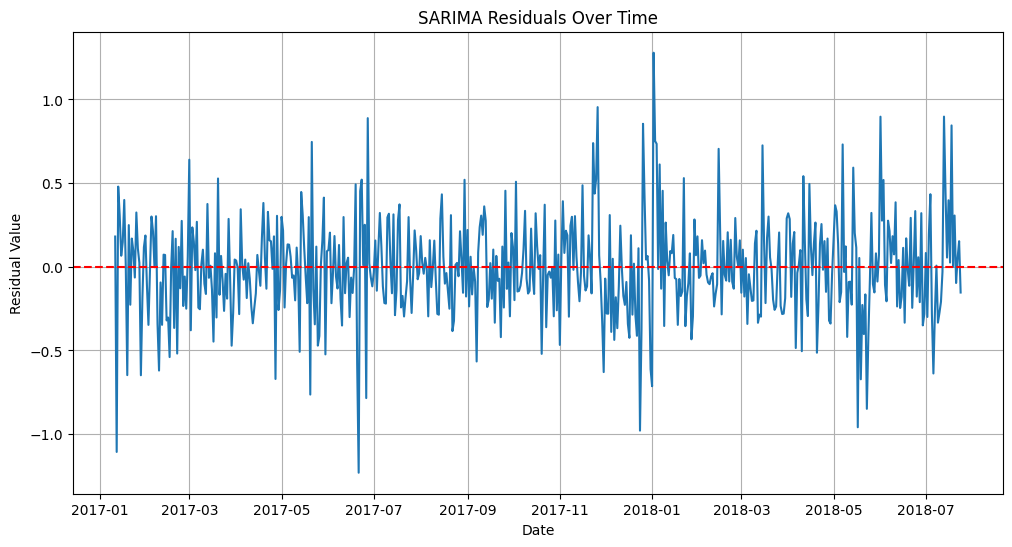

In [46]:
# Residuals vs Time
plt.figure(figsize=(12, 6))
plt.plot(train['ds'].iloc[burn_in:], sarima_residuals, label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.title('SARIMA Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.grid(True)
plt.show()

The SARIMA residuals over time did not exhibit autocorrelation, indicating that the model assumptions were satisfied.

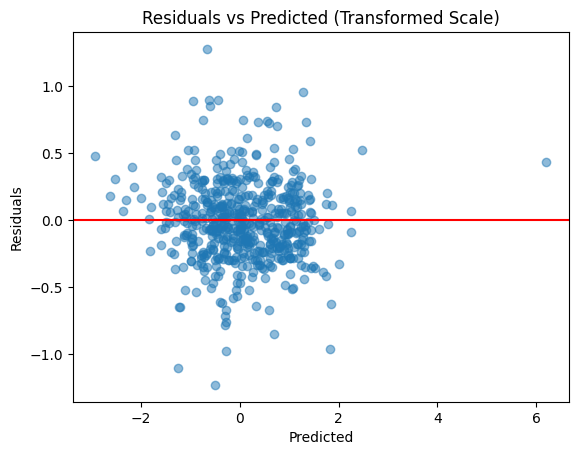

In [47]:
# Heteroscedasticity Check (Transformed Scale)
plt.scatter(sarima_results.fittedvalues.iloc[burn_in:], sarima_residuals, alpha=0.5)
plt.axhline(0, color='red')
plt.title('Residuals vs Predicted (Transformed Scale)')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.show()

The heteroscedasticity check, which plotted residuals against predicted values, showed a scattered pattern with no discernible structure, indicating that the SARIMA model assumptions were met.

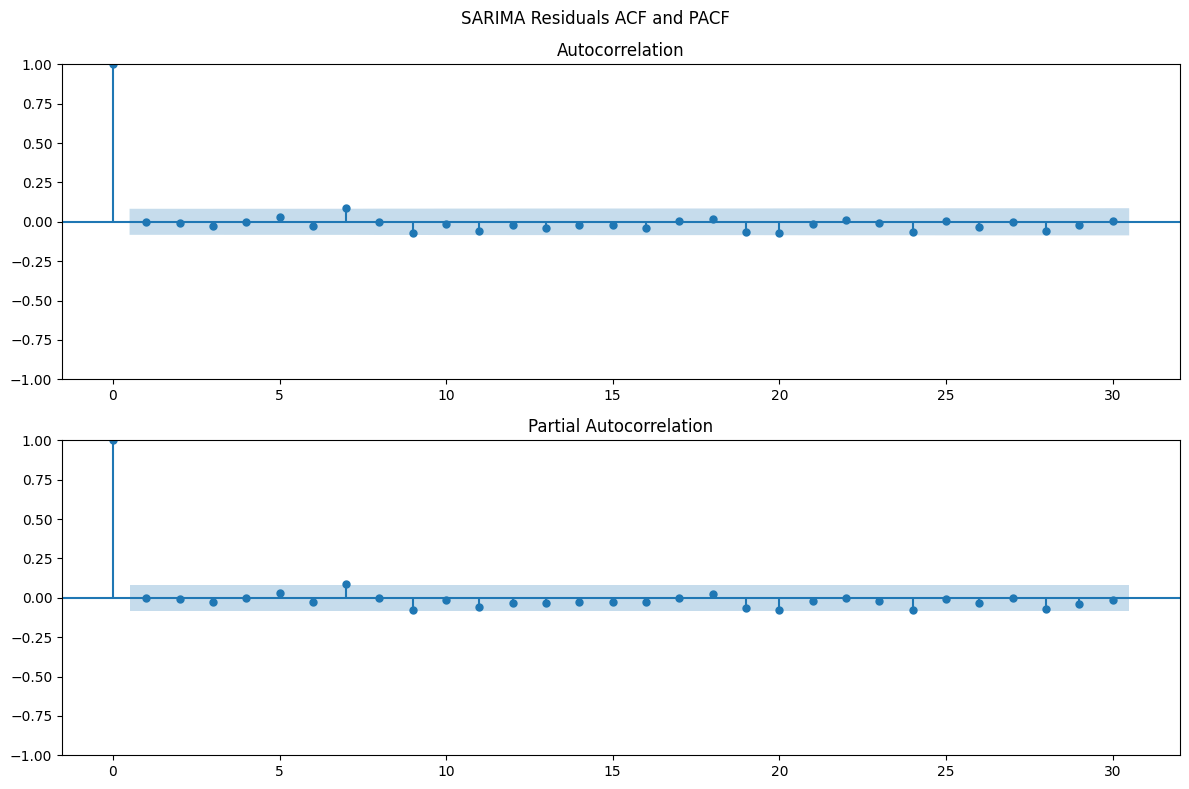

In [48]:
# ACF/PACF Plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(sarima_residuals, lags=30, alpha=0.05, ax=ax1)
plot_pacf(sarima_residuals, lags=30, alpha=0.05, ax=ax2)
plt.suptitle('SARIMA Residuals ACF and PACF')
plt.tight_layout()
plt.show()

The ACF and PACF plots showed values close to zero, indicating that the SARIMA model successfully captured all underlying patterns.

In [49]:
# Ljung-Box Test
max_lag = min(40, len(sarima_residuals)//4)
lb_test = acorr_ljungbox(sarima_residuals, lags=range(1,max_lag), return_df=True)
print("Ljung-Box Test Results:")
print(lb_test)

Ljung-Box Test Results:
      lb_stat  lb_pvalue
1    0.000036   0.995184
2    0.049690   0.975461
3    0.463200   0.926898
4    0.467035   0.976630
5    1.050431   0.958396
6    1.465269   0.961768
7    5.697519   0.575478
8    5.700258   0.680766
9    8.830823   0.453035
10   8.969856   0.534967
11  10.785074   0.461441
12  11.007674   0.528261
13  11.801050   0.544021
14  12.062727   0.601265
15  12.341527   0.653016
16  13.187705   0.658987
17  13.191824   0.723253
18  13.409340   0.766704
19  15.900328   0.663918
20  19.102637   0.515164
21  19.240487   0.569716
22  19.361723   0.622898
23  19.421568   0.676504
24  22.112674   0.572542
25  22.126012   0.628457
26  22.732567   0.648029
27  22.732633   0.699289
28  24.690520   0.644623
29  24.961645   0.680236
30  24.974938   0.726249
31  24.983882   0.768438
32  25.332569   0.792340
33  25.334724   0.827555
34  26.056602   0.833452
35  26.159964   0.859907
36  33.039485   0.610158
37  33.746611   0.622371
38  35.627832   0.579656
3

The Ljung-Box test showed a p-value greater than 0.05, further confirming that the model effectively captured all relevant patterns.

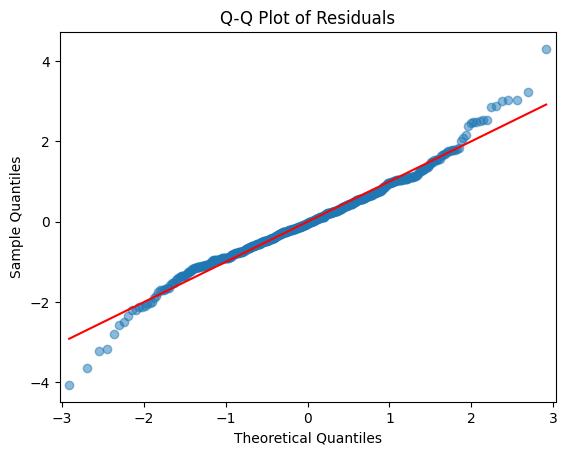

In [50]:
# Normality of Residuals
qqplot(sarima_residuals, line='s', fit=True, alpha=0.5)
plt.title('Q-Q Plot of Residuals')
plt.show()

The normality of the residuals, as indicated by the Q-Q plots, showed that the points closely overlapped the red straight line, suggesting that the residuals followed a normal distribution and thus satisfied the SARIMA model assumptions.

In [51]:
# ADF Test on Residuals
adf_test(sarima_residuals, title='Model Residuals (Transformed)')


ADF Test: Model Residuals (Transformed)
ADF Statistic: -23.610689631230425
p-value: 0.0
Critical Values:
   1%: -3.442102384299813
   5%: -2.8667242618524233
   10%: -2.569531046591633
Result: Stationary


After differencing with order d=1, the residuals has a p-value approaching zero, indicating that the model is stationary.

## Model Evaluation

In [52]:
def smape(true, pred):
    """Calculate Symmetric Mean Absolute Percentage Error (SMAPE)"""
    true = np.array(true)
    pred = np.array(pred)
    # Avoid division by zero by adding a small constant if needed
    denominator = (np.abs(true) + np.abs(pred))
    # When both true and pred are zero, the error is zero
    smape_val = np.where(denominator == 0,
                         0.0,
                         200 * np.abs(pred - true) / denominator)
    return np.mean(smape_val)

In [53]:
def calculate_metrics(true, pred, model_name):
    mask = true != 0  # Only calculate for non-zero actuals
    mape = np.mean(np.abs((true[mask] - pred[mask]) / true[mask])) * 100

    metrics = {
        'Model': model_name,
        'MSE': mean_squared_error(true, pred),
        'RMSE': np.sqrt(mean_squared_error(true, pred)),
        'MAE': mean_absolute_error(true, pred),
        'MAPE': mape,
        'SMAPE': smape(true, pred)
    }
    return metrics

In [54]:
# Get training predictions AFTER burn-in (skip unstable initial points)
pred = sarima_results.get_prediction(start=burn_in)
sarima_train_pred_transformed = pred.predicted_mean

# Capture training confidence intervals
train_ci_transformed = pred.conf_int()

# Align actuals (skip burn-in days)
actuals_train = train['y_original'].iloc[burn_in:]

# Inverse transform to original scale
sarima_train_pred = pt.inverse_transform(
    sarima_train_pred_transformed.values.reshape(-1, 1)
).flatten().clip(min=0)

# Inverse transform training confidence intervals
sarima_train_ci_lower = pt.inverse_transform(
    train_ci_transformed.iloc[:, 0].values.reshape(-1, 1)
).flatten().clip(min=0)
sarima_train_ci_upper = pt.inverse_transform(
    train_ci_transformed.iloc[:, 1].values.reshape(-1, 1)
).flatten().clip(min=0)

In [55]:
# Align lengths between actuals and predictions
if len(actuals_train) != len(sarima_train_pred):
    min_length = min(len(actuals_train), len(sarima_train_pred))
    actuals_train = actuals_train.iloc[:min_length]
    sarima_train_pred = sarima_train_pred[:min_length]

In [56]:
# Calculate metrics
sarima_train_metrics = calculate_metrics(actuals_train, sarima_train_pred, 'SARIMA (Train)')
sarima_test_metrics = calculate_metrics(test['y_original'], sarima_pred, 'SARIMA (Test - 1-Day Rolling Window)')
sarima_test_baseline_metrics = calculate_metrics(test['y_original'], sarima_pred_baseline, 'SARIMA (Test - Baseline)')

**Baseline (added a new metrics)**

In [57]:
# PIC & PIW
within_ci_baseline = (test['y_original'] >= sarima_baseline_ci_lower) & (test['y_original'] <= sarima_baseline_ci_upper)
pic_test_baseline = np.mean(within_ci_baseline) * 100
piw_test_baseline = np.mean(sarima_baseline_ci_upper - sarima_baseline_ci_lower)

# MDA
prev_actual_baseline = train['y_original'].iloc[-1]
mda_correct_baseline = 0
for i in range(len(test)):
    current_actual_baseline = test['y_original'].iloc[i]
    current_pred_baseline = sarima_pred_baseline[i]
    actual_dir_baseline = current_actual_baseline > prev_actual_baseline
    forecast_dir_baseline = current_pred_baseline > prev_actual_baseline
    if actual_dir_baseline == forecast_dir_baseline:
        mda_correct_baseline += 1
    prev_actual_baseline = current_actual_baseline
mda_test_baseline = (mda_correct_baseline / len(test)) * 100

# Forecast Bias
forecast_bias_test_baseline = np.mean(test['y_original'] - sarima_pred_baseline)

# Update test metrics
sarima_test_baseline_metrics['PIW'] = piw_test_baseline
sarima_test_baseline_metrics['PIC'] = pic_test_baseline
sarima_test_baseline_metrics['MDA'] = mda_test_baseline
sarima_test_baseline_metrics['Forecast Bias'] = forecast_bias_test_baseline

**1-Day Rolling Window (added a new metrics)**

In [58]:
# New Metrics for test set
# PIC & PIW
within_ci = (test['y_original'] >= sarima_ci_lower) & (test['y_original'] <= sarima_ci_upper)
pic_test = np.mean(within_ci) * 100
piw_test = np.mean(sarima_ci_upper - sarima_ci_lower)

# MDA
prev_actual = train['y_original'].iloc[-1]
mda_correct = 0
for i in range(len(test)):
    current_actual = test['y_original'].iloc[i]
    current_pred = sarima_pred[i]
    actual_dir = current_actual > prev_actual
    forecast_dir = current_pred > prev_actual
    if actual_dir == forecast_dir:
        mda_correct += 1
    prev_actual = current_actual
mda_test = (mda_correct / len(test)) * 100

# Forecast Bias
forecast_bias_test = np.mean(test['y_original'] - sarima_pred)

# Update test metrics
sarima_test_metrics['PIW'] = piw_test
sarima_test_metrics['PIC'] = pic_test
sarima_test_metrics['MDA'] = mda_test
sarima_test_metrics['Forecast Bias'] = forecast_bias_test

In [59]:
# Compute new metrics for training set
# PIC & PIW
within_ci_train = (actuals_train >= sarima_train_ci_lower) & (actuals_train <= sarima_train_ci_upper)
pic_train = np.mean(within_ci_train) * 100
piw_train = np.mean(sarima_train_ci_upper - sarima_train_ci_lower)

# MDA
prev_actual = train['y_original'].iloc[burn_in - 1] if burn_in > 0 else actuals_train.iloc[0]
mda_correct_train = 0
for i in range(len(actuals_train)):
    current_actual = actuals_train.iloc[i]
    current_pred = sarima_train_pred[i]
    actual_dir = current_actual > prev_actual
    forecast_dir = current_pred > prev_actual
    if actual_dir == forecast_dir:
        mda_correct_train += 1
    prev_actual = current_actual
mda_train = (mda_correct_train / len(actuals_train)) * 100

# Forecast Bias
forecast_bias_train = np.mean(actuals_train - sarima_train_pred)

# Update train metrics
sarima_train_metrics['PIW'] = piw_train
sarima_train_metrics['PIC'] = pic_train
sarima_train_metrics['MDA'] = mda_train
sarima_train_metrics['Forecast Bias'] = forecast_bias_train

In [60]:
# Combine results
results_df = pd.DataFrame([sarima_train_metrics, sarima_test_baseline_metrics, sarima_test_metrics])

In [61]:
# Overfitting check
train_rmse = sarima_train_metrics['RMSE']
test_rmse = sarima_test_metrics['RMSE']

train_rel_error = (train_rmse / train['y_original'].iloc[burn_in:].mean()) * 100
test_rel_error = (test_rmse / test['y_original'].iloc[burn_in:].mean()) * 100

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Average Daily Orders on the Train Set: {train['y_original'].mean():.2f}")
print(f"Average Daily Orders on the Test Set: {test['y_original'].mean():.2f}")
print(f"Train RMSE Relative Error: {train_rel_error:.2f}%")
print(f"Test RMSE Relative Error: {test_rel_error:.2f}%")

gap_train_test = test_rel_error - train_rel_error

if gap_train_test > 10:
    print(f"\nThe test error is {gap_train_test:.2f}% worse than the training error.")
    print("⚠️ Warning: Potential overfitting detected (Train-Test RMSE Gap >10%).")
elif gap_train_test < 0:
    print(f"\n✅ The test error is {abs(gap_train_test):.2f}% better than the training error.")
else:
    print(f"\nThe test error is {gap_train_test:.2f}% worse than the training error.")
    print("✅ No significant overfitting detected (Train-Test RMSE Gap ≤10%).")


Train RMSE: 25.79
Test RMSE: 30.32
Average Daily Orders on the Train Set: 154.77
Average Daily Orders on the Test Set: 254.53
Train RMSE Relative Error: 16.38%
Test RMSE Relative Error: 11.91%

✅ The test error is 4.47% better than the training error.


In [62]:
print("=== Model Performance ===")
print(results_df.to_markdown(tablefmt="grid", index=False))

=== Model Performance ===
+--------------------------------------+----------+---------+---------+---------+---------+----------+---------+---------+-----------------+
| Model                                |      MSE |    RMSE |     MAE |    MAPE |   SMAPE |      PIW |     PIC |     MDA |   Forecast Bias |
+======================================+==========+=========+=========+=========+=========+==========+=========+=========+=================+
| SARIMA (Train)                       |  665.121 | 25.7899 | 18.982  | 15.1698 | 14.254  |  97.6824 | 94.2857 | 78.0357 |     -0.235723   |
+--------------------------------------+----------+---------+---------+---------+---------+----------+---------+---------+-----------------+
| SARIMA (Test - Baseline)             | 2216.4   | 47.0786 | 36.3243 | 15.782  | 14.5692 | 153.695  | 86.6667 | 66.6667 |      0.00261878 |
+--------------------------------------+----------+---------+---------+---------+---------+----------+---------+---------+------

From the metrics above, I chose RMSE as my priority metric because the dataset contains outliers (around the Black Friday events), and I wanted to penalize this effect. MAP or SMAPE is not accurate for this dataset because it contains zero or near-zero values.

I chose the evaluation metrics from the 1-day rolling window instead of the baseline forecast because it is more accurate.
- RMSE is 30, meaning that, on average, predictions are off by 30 orders per day.
- PIW (Prediction Interval Width) is 126 for the 1-day rolling window, meaning that prediction ranges are 126 orders wide (e.g., 100–226).
- PIC (Prediction Interval Coverage) is 93, meaning 93% of actual sales fall within the predicted range.
- MDA (Mean Directional Accuracy) is 73, meaning that 73% of trend predictions (up/down compared to yesterday) are correct.
- Forecast bias (deviation) is -6, meaning the model tends to underpredict by 6 orders.

In [63]:
print(sarima_results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                     y_transformed   No. Observations:                  570
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood                -190.265
Date:                           Sat, 26 Apr 2025   AIC                            394.531
Time:                                   15:30:02   BIC                            424.950
Sample:                                        0   HQIC                           406.399
                                           - 570                                         
Covariance Type:                             opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
is_black_friday          1.7251      0.117     14.767      0.000       1.496       1.954
is_black_frid

As we can see from the model summary, the model has the best parameters (1, 1, 1) × (1, 0, 1, 7) (p, d, q) × (P, D, Q, S). All the features, such as is_black_friday and is_black_friday_peak, show significant effects, as indicated by very low p-values (P > |z|). The probability from the Ljung-Box test being greater than 0.05 indicates that the residuals are white noise.

## Model Visualization

In [64]:
# Preparing the train set
train_dates = train['ds'].iloc[d:]  # d = differencing order

# Get aligned dates, actuals, and predictions AFTER burn-in
train_dates = train['ds'].iloc[burn_in:burn_in + len(sarima_train_pred)]
actuals_train = train['y_original'].iloc[burn_in:burn_in + len(sarima_train_pred)]

# Create DataFrame for train forecasts
train_forecast_df = pd.DataFrame({
    'ds': train_dates,
    'y_true': actuals_train,
    'y_pred': sarima_train_pred
})

# Black Fridays
black_friday_dates = pd.DataFrame({
    'holiday': 'black_friday',
    'ds': pd.to_datetime(['2017-11-24'])
})

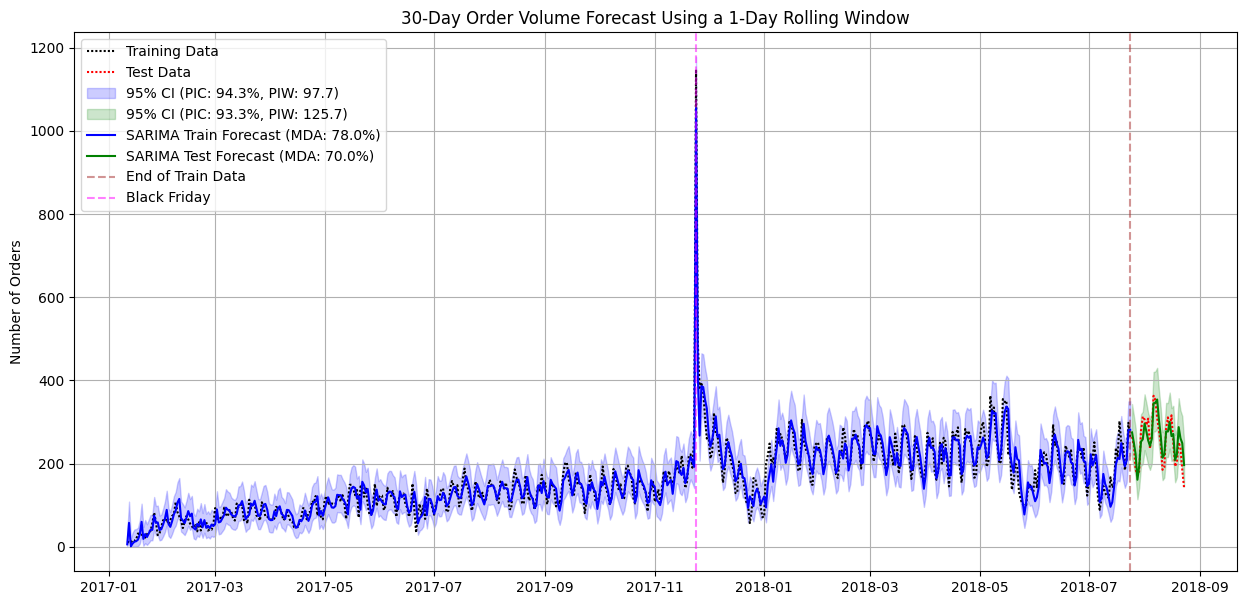

In [65]:
# Create 30-Day Order Volume Forecast Chart
plt.figure(figsize=(15, 7))

# Plot training data
plt.plot(train['ds'].iloc[burn_in:], train['y_original'].iloc[burn_in:], label='Training Data', linestyle=(0, (1, 1)), color='black')

# Plot test data
plt.plot(test['ds'], test['y_original'], label='Test Data', linestyle=(0, (1, 1)), color='red')

# Add shaded confidence intervals to the full dataset plot
plt.fill_between(train['ds'].iloc[burn_in:], sarima_train_ci_lower, sarima_train_ci_upper,
    color='blue', alpha=0.2,label=f'95% CI (PIC: {pic_train:.1f}%, PIW: {piw_train:.1f})')

plt.fill_between(test['ds'], sarima_ci_lower, sarima_ci_upper, color='green', alpha=0.2, label=f'95% CI (PIC: {pic_test:.1f}%, PIW: {piw_test:.1f})')

# Plot train forecasts
plt.plot(train_forecast_df['ds'], train_forecast_df['y_pred'], label=f'SARIMA Train Forecast (MDA: {mda_train:.1f}%)', color='blue')

# Plot test forecasts
plt.plot(test['ds'], sarima_pred, label=f'SARIMA Test Forecast (MDA: {mda_test:.1f}%)', color='green')

# Highlight key dates
plt.axvline(x=split_date, color='brown', linestyle='--', alpha=0.5, label='End of Train Data')

# Black Friday markers (optional)
bf_date = pd.to_datetime('2017-11-24')
if bf_date in train['ds'].values:
    plt.axvline(x=bf_date, color='magenta', linestyle='--', alpha=0.5, label='Black Friday')

# Formatting
plt.title('30-Day Order Volume Forecast Using a 1-Day Rolling Window')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

From the graph above, the 1-day rolling window successfully forecasted the test data and closely matches the actual values.

In [66]:
print("="*50)
print("SARIMA Eval Baseline Forecast:")
print("="*50)
print(pd.DataFrame({
    'date': test['ds'],
    'forecast': sarima_pred_baseline,
    'lower_ci': sarima_baseline_ci_lower,
    'upper_ci': sarima_baseline_ci_upper
}))

SARIMA Eval Baseline Forecast:
          date    forecast    lower_ci    upper_ci
570 2018-07-25  274.928475  241.698414  310.119450
571 2018-07-26  256.834764  219.051707  297.367520
572 2018-07-27  232.128052  192.635561  274.983264
573 2018-07-28  190.390668  151.823846  232.932000
574 2018-07-29  214.315632  170.856710  262.261360
575 2018-07-30  285.187606  232.443044  342.857359
576 2018-07-31  273.593925  219.313461  333.350387
577 2018-08-01  280.138984  222.003483  344.440375
578 2018-08-02  260.909576  202.107372  326.549951
579 2018-08-03  235.814790  177.533448  301.616760
580 2018-08-04  193.722146  138.874503  256.839366
581 2018-08-05  217.818537  157.632243  286.831526
582 2018-08-06  289.165315  217.604964  369.981823
583 2018-08-07  277.498026  205.247623  359.651925
584 2018-08-08  284.084410  208.312563  370.536361
585 2018-08-09  264.731585  189.328506  351.601779
586 2018-08-10  239.467824  165.759910  325.450766
587 2018-08-11  197.067449  128.575388  278.745100


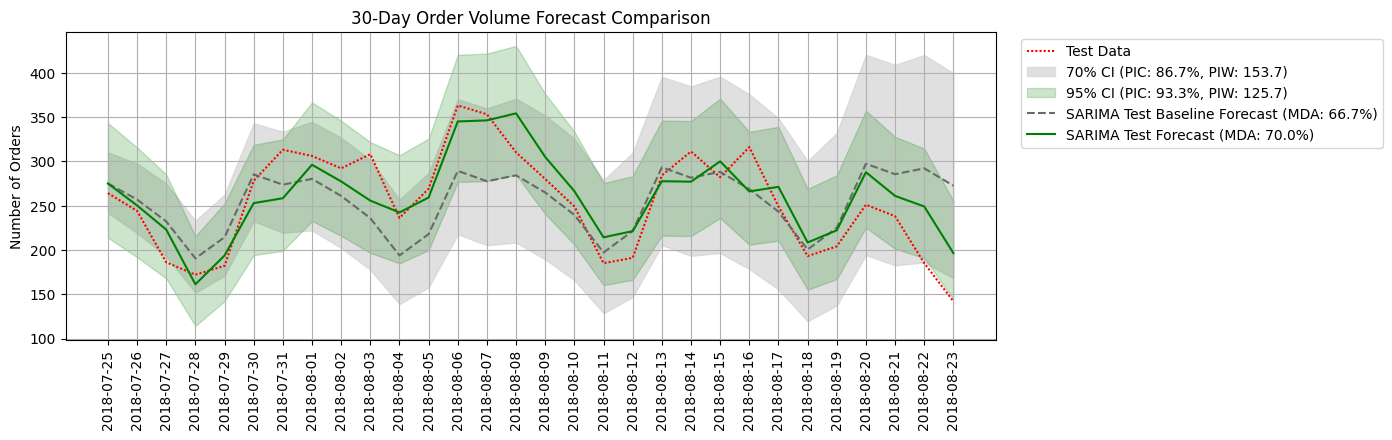

In [67]:
# Create 30-Day Order Volume Forecast Comparison Chart
plt.figure(figsize=(12, 4))

# Plot test data (actual values)
plt.plot(test['ds'], test['y_original'], label='Test Data', linestyle=(0, (1, 1)), color='red')

# Plot baseline confidence interval
plt.fill_between(test['ds'], sarima_baseline_ci_lower, sarima_baseline_ci_upper, color='lightgray', alpha=0.7,
                label=f'70% CI (PIC: {pic_test_baseline:.1f}%, PIW: {piw_test_baseline:.1f})')

# Plot confidence interval
plt.fill_between(test['ds'], sarima_ci_lower, sarima_ci_upper, color='green', alpha=0.2,
                label=f'95% CI (PIC: {pic_test:.1f}%, PIW: {piw_test:.1f})')

# Plot baseline test forecasts
plt.plot(test['ds'], sarima_pred_baseline, label=f'SARIMA Test Baseline Forecast (MDA: {mda_test_baseline:.1f}%)', color='dimgray', linestyle='--')

# Plot test forecasts
plt.plot(test['ds'], sarima_pred, label=f'SARIMA Test Forecast (MDA: {mda_test:.1f}%)', color='green')

# Formatting
plt.title('30-Day Order Volume Forecast Comparison')
plt.ylabel('Number of Orders')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(test['ds'], rotation=90)
plt.grid(True)
plt.show()

From the graph above, we can see that the baseline forecast was added to allow comparison with the 1-day rolling window forecast. Although the baseline forecast does not include 1-day self-correction like the rolling forecast, its performance still looks good, as indicated by the overlapping confidence interval with the test data.

In [68]:
# Training data (after burn-in)
actual_train = train[['ds', 'y_original']].iloc[burn_in:].rename(
    columns={'y_original': 'actual'}
)

# Test data
actual_test = test[['ds', 'y_original']].rename(
    columns={'y_original': 'actual'}
)

# Combine both
actual_df = pd.concat([actual_train, actual_test])

In [69]:
# Training forecast
train_forecast = pd.DataFrame({
    'ds': train['ds'].iloc[burn_in:],
    'forecast': train_forecast_df['y_pred'],
    'ci_lower': sarima_train_ci_lower,
    'ci_upper': sarima_train_ci_upper
})

# Test forecast
test_forecast = pd.DataFrame({
    'ds': test['ds'],
    'forecast': sarima_pred,
    'ci_lower': sarima_ci_lower,
    'ci_upper': sarima_ci_upper
})

# Combine both
forecast_df = pd.concat([train_forecast, test_forecast])

In [70]:
# Merge data first to ensure alignment
merged = pd.merge(
    actual_df[['ds', 'actual']],
    forecast_df[['ds', 'forecast']],
    on='ds',
    how='inner'
)

In [71]:
def plot_forecast_vs_actual_orders(merged, year=None, month=None,
                                  show_trend_line=True, show_all_daily_ticks=False):
    """
    Plot daily olist order forecast accuracy (actual = baseline).

    Parameters:
    - merged: DataFrame containing actual and forecast data with 'ds', 'actual', and 'forecast' columns
    - year/month: Filter to specific month (e.g., March 2024)
    - show_trend_line: Add a line connecting daily deviations (default: True)
    - show_all_daily_ticks: Show every date label (default: False)
    """

    if year and month:
        merged = merged[(merged['ds'].dt.year == year) &
                       (merged['ds'].dt.month == month)]
        if merged.empty:
            print(f"No data for {month}/{year}")
            return

    # Calculate forecast deviation (forecast - actual)
    deviation = merged['forecast'] - merged['actual']

    # Create plot
    plt.figure(figsize=(12, 5))

    # Plot deviations
    over_mask = deviation > 0
    under_mask = deviation < 0
    plt.scatter(merged['ds'][over_mask], deviation[over_mask],
                color='green', marker='o', alpha=0.7, label='Forecast too high')
    plt.scatter(merged['ds'][under_mask], deviation[under_mask],
                color='red', marker='o', alpha=0.7, label='Forecast too low')

    # Reference lines
    plt.axhline(0, color='black', linestyle='-', alpha=0.3, label='Actual Orders (normalized)')
    plt.axhline(deviation.mean(), color='magenta', linestyle='--',
                label=f'Avg Deviation: {deviation.mean():.0f} orders/day')

    # Trend line (optional)
    if show_trend_line:
        plt.plot(merged['ds'], deviation, 'b--', alpha=0.5, linewidth=1,
                label='Deviation Trend')

    # Formatting
    title = 'Daily Olist Orders: Forecast vs Actual'
    if year and month:
        title += f' ({month_name[month]} {year})'
        if show_all_daily_ticks:
            plt.xticks(merged['ds'], rotation=0, fontsize=10)
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d'))
        else:
            plt.xticks(rotation=0)
    else:
        title += ' (All Historical Data)'

    plt.title(title, fontsize=14, pad=20)
    plt.ylabel('Forecast Deviation', fontsize=10)
    plt.grid(alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()

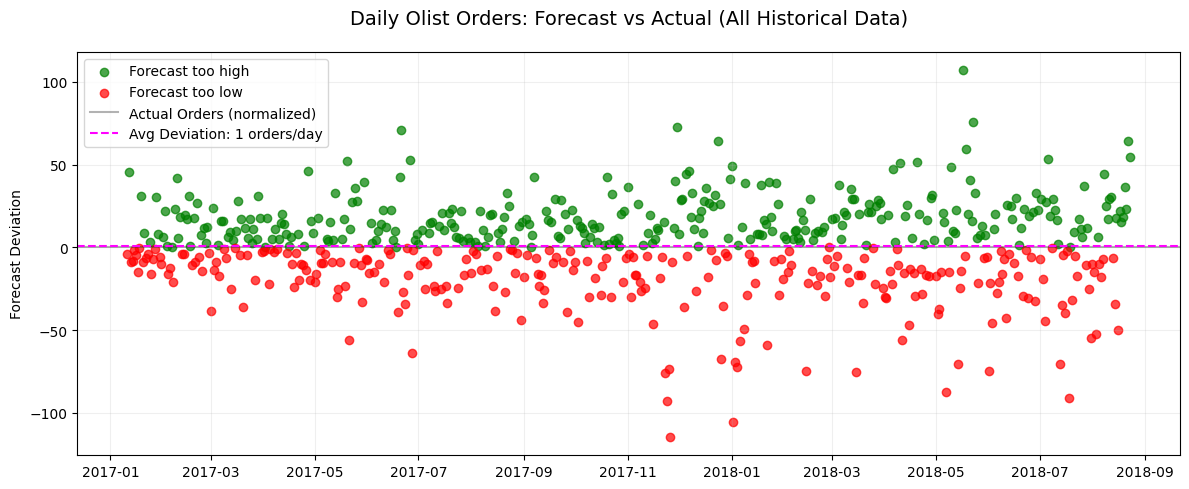

In [72]:
plot_forecast_vs_actual_orders(merged, show_trend_line=False)

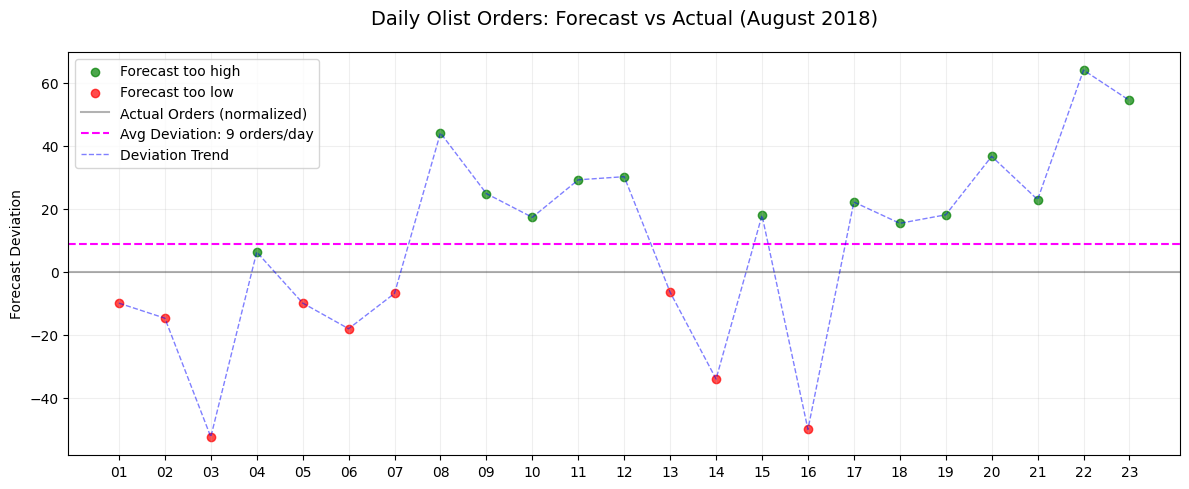

In [73]:
plot_forecast_vs_actual_orders(merged, 2018, 8, show_all_daily_ticks=True)

From the graph above, the actual order volume was normalized to 0, and we can see where the forecast for each day was too high (green) or too low (red). The average deviation was 9 orders per day.

## Business Impact Translation

In [74]:
# Convert RMSE to business metrics
avg_daily_orders = test['y_original'].mean()
rmse_value = float(results_df['RMSE'][2])
relative_rmse = (rmse_value / avg_daily_orders) * 100  # Percentage of average orders
exchange_rate = 5.81

print("="*85)
print("BUSINESS IMPACT ANALYSIS (30-Day Order Volume Forecast Using a 1-Day Rolling Window)")
print("="*85)
print(f"Average Daily Orders: {avg_daily_orders:.0f}")
print(f"Average Deviation: {rmse_value:.0f} orders ({relative_rmse:.1f}% of average)")

# Error cost analysis (in local currency)
under_prediction_cost = 50  # R$50 lost profit per under-predicted order
over_prediction_cost = 30   # R$30 excess cost per over-predicted order

# Calculate prediction errors
errors = np.array([sarima_pred[i] - test['y_original'].iloc[i] for i in range(len(test))])

# Calculate monetary impact of errors
weighted_errors = np.where(
    errors > 0,  # Over-prediction
    over_prediction_cost * abs(errors),  # Direct cost per order
    under_prediction_cost * abs(errors)  # Direct cost per order
)

avg_daily_cost = weighted_errors.mean()

print("\n" + "="*85)
print("ERROR COST ANALYSIS (LOCAL CURRENCY - R$)")
print("="*85)
print(f"Under-prediction Cost: R${under_prediction_cost:.0f} per order (lost profit)")
print(f"Over-prediction Cost: R${over_prediction_cost:.0f} per order (excess inventory)")
print(f"Daily Average Cost: R${avg_daily_cost:,.0f}")
print(f"Monthly Error Cost Impact: R${avg_daily_cost * 30:,.0f}")

print("\n" + "="*85)
print("ERROR COST ANALYSIS (USD $)")
print("="*85)
print(f"Under-prediction Cost: ${under_prediction_cost / exchange_rate:.0f} per order")
print(f"Over-prediction Cost: ${over_prediction_cost / exchange_rate:.0f} per order")
print(f"Daily Average Cost: ${avg_daily_cost / exchange_rate:,.0f}")
print(f"Monthly Error Cost Impact: ${avg_daily_cost * 30 / exchange_rate:,.0f}")
print("="*85)

BUSINESS IMPACT ANALYSIS (30-Day Order Volume Forecast Using a 1-Day Rolling Window)
Average Daily Orders: 255
Average Deviation: 30 orders (11.9% of average)

ERROR COST ANALYSIS (LOCAL CURRENCY - R$)
Under-prediction Cost: R$50 per order (lost profit)
Over-prediction Cost: R$30 per order (excess inventory)
Daily Average Cost: R$958
Monthly Error Cost Impact: R$28,728

ERROR COST ANALYSIS (USD $)
Under-prediction Cost: $9 per order
Over-prediction Cost: $5 per order
Daily Average Cost: $165
Monthly Error Cost Impact: $4,945


# Retrain the Model on Full Dataset

## Yeo-Johnson Transformation

In [75]:
# Initialize transformer
pt_full = PowerTransformer(method='yeo-johnson')

In [76]:
# Appyling fit_transform on full dataset
daily_orders['y_transformed'] = pt_full.fit_transform(daily_orders[['y']]).flatten()

In [77]:
# Keep original 'y' (unchanged)
daily_orders['y_original'] = daily_orders['y']

## Retrain the model using SARIMA on Full Dataset

In [78]:
print("Retraining SARIMA on full dataset...")

endog_full = daily_orders['y_transformed'].reset_index(drop=True)
exog_full = daily_orders[regressor_features].reset_index(drop=True)

final_sarima_full = SARIMAX(
    endog_full,
    exog=exog_full,
    order=best_params,
    seasonal_order=best_seasonal_params,
    enforce_stationarity=True,
    enforce_invertibility=True
)

sarima_full_results = final_sarima_full.fit(disp=False)

Retraining SARIMA on full dataset...


## Save the Model for Deployment

In [79]:
save_model_path = base_path
saved_models_dir = Path(save_model_path) / 'saved_models'
saved_models_dir.mkdir(parents=True, exist_ok=True)  # Create dir if missing

# Get current time in GMT+7 (Asia/Bangkok, Asia/Jakarta, etc.)
tz = pytz.timezone('Asia/Bangkok')
current_time = datetime.now(tz)

version = current_time.strftime("%Y%m%d_%H%M")
deploy_model_path = saved_models_dir / f'order_volume_sarima_full_v{version}.joblib'

# Save both SARIMA model and PowerTransformer
deploy_artifact = {
    'model': sarima_full_results,
    'transformer': pt_full
}

# Save the model
joblib.dump(deploy_artifact, deploy_model_path)

print(f"✅ Model will be saved to: {deploy_model_path}")
print(f"Time used: {current_time} (GMT+7)")

✅ Model will be saved to: /content/drive/MyDrive/dibimbing.id/Day44 - Final Project Data Science/Project/saved_models/order_volume_sarima_full_v20250426_2230.joblib
Time used: 2025-04-26 22:30:06.681804+07:00 (GMT+7)


## Generate Forecast

In [80]:
# Generate future dates for next 30 days
last_date = daily_orders['ds'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Create DataFrame with future dates
future_df = pd.DataFrame({'ds': future_dates})

# Generate features (MUST use same create_features() as training)
future_df = create_features(future_df)  # This now handles dynamic Black Fridays
future_exog = future_df[regressor_features]  # Align columns with training

In [81]:
forecast = sarima_full_results.get_forecast(
    steps=len(future_dates),
    exog=future_exog  # Pass pre-generated exogenous vars
)

In [82]:
# Get predictions and confidence intervals
future_pred_transformed = forecast.predicted_mean

# I think there's a 30% chance the true value falls outside this range.
future_ci = forecast.conf_int(alpha=0.30)  # 100% - 70% CI → alpha=0.30

## Inverse Yeo-Johnson Transformation

In [83]:
future_pred = pt_full.inverse_transform(
    future_pred_transformed.values.reshape(-1, 1)
).flatten().clip(min=0)

In [84]:
sarima_beyond_ci_lower = pt_full.inverse_transform(future_ci.iloc[:, 0].values.reshape(-1, 1)).flatten()
sarima_beyond_ci_upper = pt_full.inverse_transform(future_ci.iloc[:, 1].values.reshape(-1, 1)).flatten()

# Verify lengths
assert len(future_pred) == len(sarima_beyond_ci_lower) == len(sarima_beyond_ci_upper) == 30

In [85]:
# Prepare final output DataFrame
sarima_future_forecast = pd.DataFrame({
    'ds': future_dates,
    'yhat': future_pred,
    'yhat_lower': sarima_beyond_ci_lower,
    'yhat_upper': sarima_beyond_ci_upper
})

## Residual Analysis

In [86]:
# Get residuals AFTER burn-in period
full_residuals = sarima_full_results.resid.iloc[burn_in:]

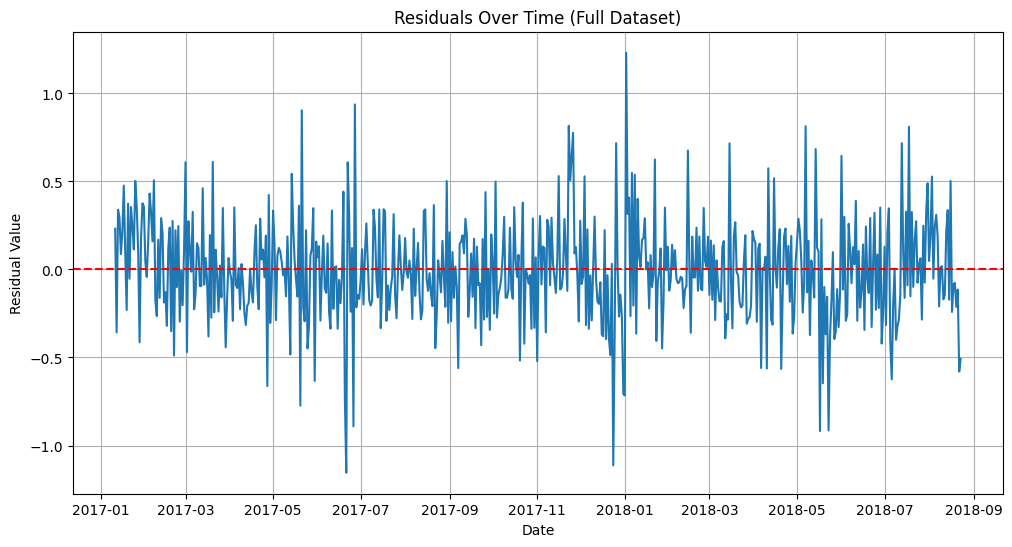

In [87]:
# Residual Plots (Transformed Scale)
plt.figure(figsize=(12, 6))
plt.plot(daily_orders['ds'].iloc[burn_in:], full_residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals Over Time (Full Dataset)')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.grid(True)
plt.show()

The SARIMA residuals over time did not exhibit autocorrelation, indicating that the model assumptions were satisfied.

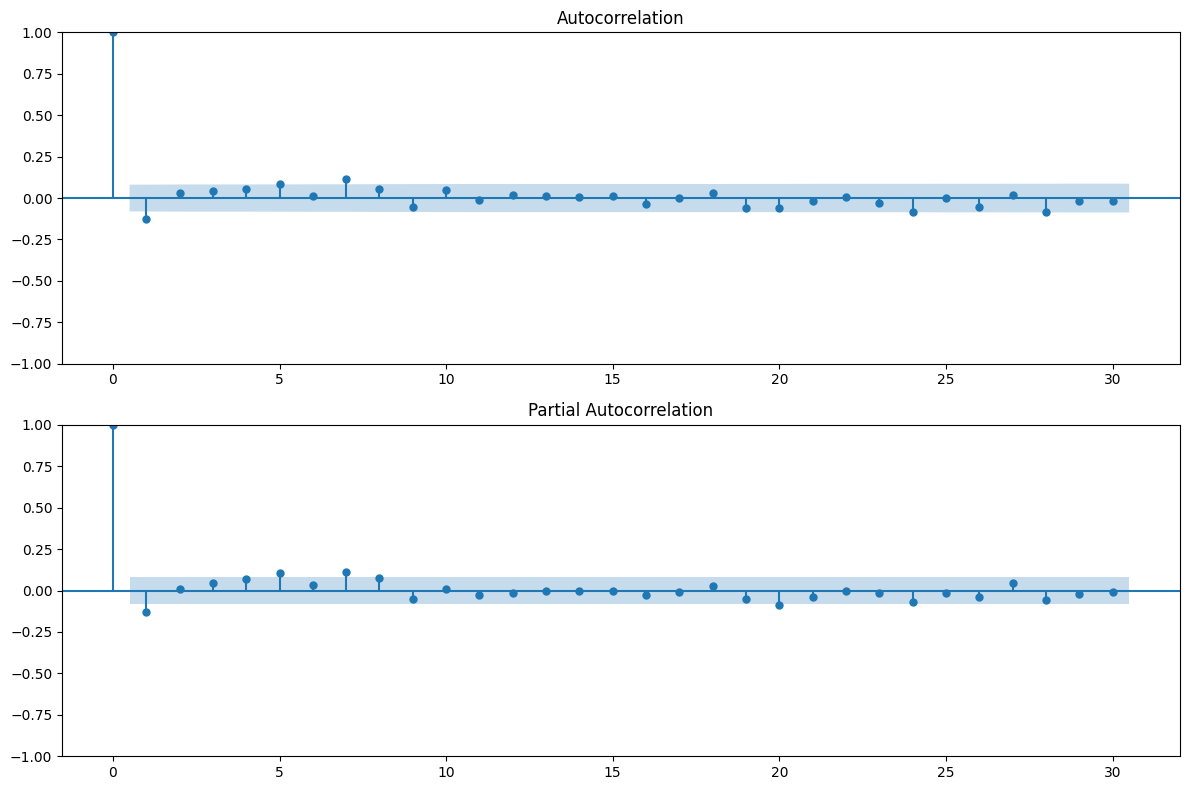

In [88]:
# ACF/PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(full_residuals, lags=30, alpha=0.05, ax=ax1)
plot_pacf(full_residuals, lags=30, alpha=0.05, ax=ax2)
plt.tight_layout()
plt.show()

The ACF and PACF plots showed values close to zero, indicating that the SARIMA model successfully captured all underlying patterns.

In [89]:
# Ljung-Box Test (for autocorrelation)
lb_test = acorr_ljungbox(full_residuals, lags=30, return_df=True)
print("Ljung-Box Test (Full Dataset):")
print(lb_test)

Ljung-Box Test (Full Dataset):
      lb_stat  lb_pvalue
1    9.842562   0.001705
2   10.320696   0.005740
3   11.279727   0.010306
4   13.242365   0.010150
5   17.835024   0.003160
6   17.904168   0.006476
7   25.755596   0.000557
8   27.656398   0.000544
9   29.244289   0.000589
10  30.667070   0.000666
11  30.746289   0.001208
12  30.973090   0.001989
13  31.068443   0.003295
14  31.094852   0.005376
15  31.209808   0.008234
16  31.886113   0.010347
17  31.887545   0.015539
18  32.560679   0.018853
19  34.871338   0.014473
20  37.216221   0.011023
21  37.416764   0.015071
22  37.437349   0.021169
23  37.897914   0.026121
24  42.498874   0.011340
25  42.499313   0.015874
26  44.420821   0.013614
27  44.668551   0.017619
28  49.174650   0.007983
29  49.338616   0.010631
30  49.540468   0.013837


Even though the Ljung-Box test shows that the p-values are mostly less than 0.05, they are not small enough to indicate significant autocorrelation. Therefore, the SARIMA model still accurately captures all the patterns.

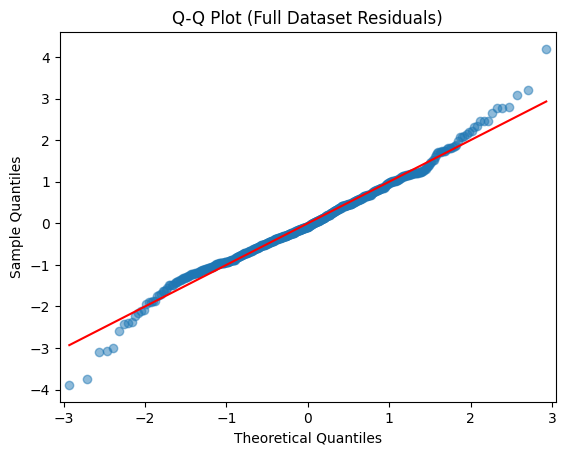

In [90]:
# Normality Check
qqplot(full_residuals, line='s', fit=True, alpha=0.5)
plt.title('Q-Q Plot (Full Dataset Residuals)')
plt.show()

The normality of the residuals, as indicated by the Q-Q plots, showed that the points closely overlapped the red straight line, suggesting that the residuals followed a normal distribution and thus satisfied the SARIMA model assumptions.

In [91]:
# ADF Test on Residuals
adf_test(full_residuals, title='Model Residuals (Full Dataset)')


ADF Test: Model Residuals (Full Dataset)
ADF Statistic: -6.089240425229679
p-value: 1.0461593391124843e-07
Critical Values:
   1%: -3.4416553818946145
   5%: -2.8665274458710064
   10%: -2.5694261699959413
Result: Stationary


After differencing with order d=1, the residuals has a p-value approaching zero, indicating that the model is stationary.

## Model Evaluation

In [92]:
# Get fitted values (transformed scale, after burn-in)
full_preds_transformed = sarima_full_results.fittedvalues.iloc[burn_in:]

# Confidence intervals (transformed scale, after burn-in)
full_ci_transformed = sarima_full_results.get_prediction(
    start=burn_in,
    end=len(daily_orders) - 1
).conf_int()

In [93]:
# Inverse transform to original scale
full_preds = pt_full.inverse_transform(
    full_preds_transformed.values.reshape(-1, 1)
).flatten().clip(min=0)

# Inverse transform to original scale (confidence intervals)
full_ci_lower = pt_full.inverse_transform(
    full_ci_transformed.iloc[:, 0].values.reshape(-1, 1)
).flatten().clip(min=0)
full_ci_upper = pt_full.inverse_transform(
    full_ci_transformed.iloc[:, 1].values.reshape(-1, 1)
).flatten().clip(min=0)

In [94]:
# Align actual values
full_actuals = daily_orders['y_original'].iloc[burn_in:burn_in + len(full_preds)]

In [95]:
# Calculate metrics
full_metrics = calculate_metrics(full_actuals, full_preds, 'SARIMA (Full Dataset)')
print(pd.DataFrame([full_metrics]).to_markdown(tablefmt="grid", index=False))

+-----------------------+---------+---------+---------+---------+---------+
| Model                 |     MSE |    RMSE |     MAE |    MAPE |   SMAPE |
+=======================+=========+=========+=========+=========+=========+
| SARIMA (Full Dataset) | 682.894 | 26.1322 | 19.5032 | 14.7558 |  14.406 |
+-----------------------+---------+---------+---------+---------+---------+


In [96]:
# --- Calculate new metrics for full dataset ---
# PIC & PIW
within_ci_full = (full_actuals >= full_ci_lower) & (full_actuals <= full_ci_upper)
pic_full = np.mean(within_ci_full) * 100
piw_full = np.mean(full_ci_upper - full_ci_lower)

# MDA
prev_actual = daily_orders['y_original'].iloc[burn_in - 1] if burn_in > 0 else full_actuals.iloc[0]
mda_correct_full = 0
for i in range(len(full_actuals)):
    current_actual = full_actuals.iloc[i]
    current_pred = full_preds[i]
    actual_dir = current_actual > prev_actual
    forecast_dir = current_pred > prev_actual
    if actual_dir == forecast_dir:
        mda_correct_full += 1
    prev_actual = current_actual
mda_full = (mda_correct_full / len(full_actuals)) * 100

# Forecast Bias
forecast_bias_full = np.mean(full_actuals - full_preds)

# Update metrics dictionary
full_metrics.update({
    'PIW': piw_full,
    'PIC': pic_full,
    'MDA': mda_full,
    'Forecast Bias': forecast_bias_full
})

In [97]:
# Compare with test metrics
print("=== Train/Test/Full Metrics Comparison ===")
print(pd.DataFrame([sarima_train_metrics, sarima_test_metrics, full_metrics]).to_markdown(tablefmt="grid", index=False))

=== Train/Test/Full Metrics Comparison ===
+--------------------------------------+---------+---------+---------+---------+---------+----------+---------+---------+-----------------+
| Model                                |     MSE |    RMSE |     MAE |    MAPE |   SMAPE |      PIW |     PIC |     MDA |   Forecast Bias |
+======================================+=========+=========+=========+=========+=========+==========+=========+=========+=================+
| SARIMA (Train)                       | 665.121 | 25.7899 | 18.982  | 15.1698 | 14.254  |  97.6824 | 94.2857 | 78.0357 |       -0.235723 |
+--------------------------------------+---------+---------+---------+---------+---------+----------+---------+---------+-----------------+
| SARIMA (Test - 1-Day Rolling Window) | 919.491 | 30.3231 | 25.402  | 10.8047 | 10.3505 | 125.703  | 93.3333 | 70      |       -5.84887  |
+--------------------------------------+---------+---------+---------+---------+---------+----------+---------+------

As we can see here, in the comparison of the model descriptions, the RMSE of the SARIMA (Full Dataset) model lies between the SARIMA (Train) and SARIMA (Test - 1-Day Rolling Window) results. This effect occurs because the full dataset forecast evaluates all historical dates, not just the test set (the last 30 days).

In [98]:
print(sarima_full_results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                     y_transformed   No. Observations:                  600
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood                -123.755
Date:                           Sat, 26 Apr 2025   AIC                            261.509
Time:                                   15:30:07   BIC                            292.276
Sample:                                        0   HQIC                           273.487
                                           - 600                                         
Covariance Type:                             opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
is_black_friday          1.4612      0.114     12.774      0.000       1.237       1.685
is_black_frid

Like the model summary for the test evaluation forecast, the model summary on the full dataset shows that the model has the best parameters (1, 1, 1) × (1, 0, 1, 7) (p, d, q) × (P, D, Q, S). All the features, such as is_black_friday and is_black_friday_peak, show significant effects, as indicated by very low p-values (P > |z|). The probability from the Ljung-Box test being greater than 0.05 indicates that the residuals are white noise.

## Model Visualization

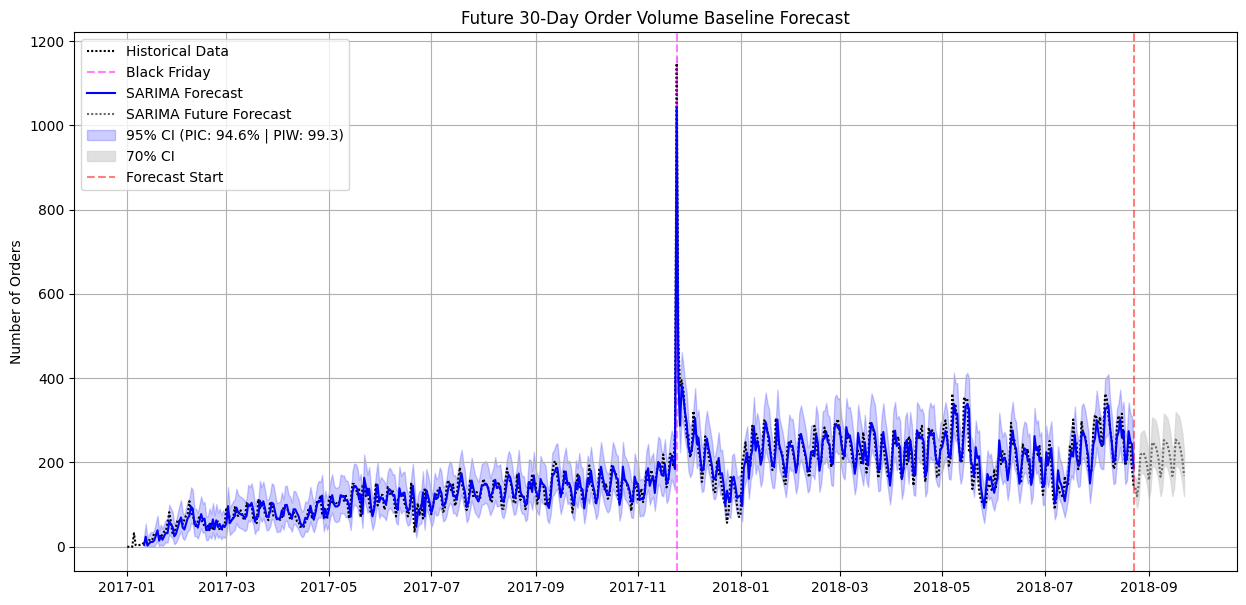

In [99]:
plt.figure(figsize=(15, 7))

# Historical Data
plt.plot(daily_orders['ds'], daily_orders['y_original'], label='Historical Data', linestyle=(0, (1, 1)), color='black')

# Highlight Black Friday dates with only one legend entry
black_friday_label_added = False
for bf_date in black_friday_dates['ds']:
    if bf_date in train['ds'].values:
        plt.axvline(
            x=bf_date,
            color='magenta',
            linestyle='--',
            alpha=0.5,
            label='Black Friday' if not black_friday_label_added else ""
        )
        black_friday_label_added = True

# Model Fit (after burn-in)
plt.plot(daily_orders['ds'].iloc[burn_in:], full_preds, label='SARIMA Forecast', color='blue')

# Future Forecasts
plt.plot(sarima_future_forecast['ds'], sarima_future_forecast['yhat'], label='SARIMA Future Forecast', color='dimgray', linestyle=(0, (1, 1)))

# Add shaded confidence intervals to the full dataset plot
plt.fill_between(daily_orders['ds'].iloc[burn_in:], full_ci_lower, full_ci_upper,
    color='blue', alpha=0.2,label=f'95% CI (PIC: {pic_full:.1f}% | PIW: {piw_full:.1f})')

# Confidence Intervals
plt.fill_between(sarima_future_forecast['ds'],
                 sarima_future_forecast['yhat_lower'],
                 sarima_future_forecast['yhat_upper'],
                 color='lightgray', alpha=0.7, label='70% CI')

# Annotations
plt.axvline(x=daily_orders['ds'].max(), color='red',  linestyle='--', alpha=0.5, label='Forecast Start')
plt.title('Future 30-Day Order Volume Baseline Forecast')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

The graph above shows the forecast of the next 30 days of orders beyond the dataset, based on the full dataset.

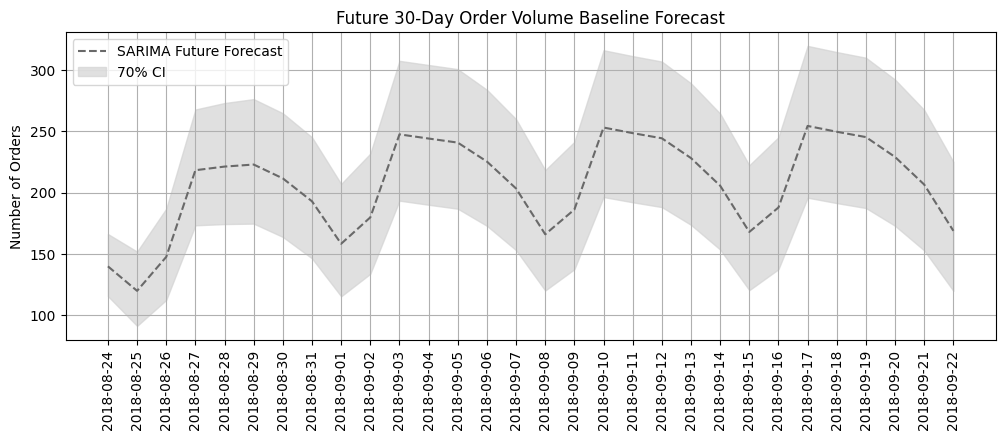

In [100]:
plt.figure(figsize=(12, 4))

# Future Forecasts
plt.plot(sarima_future_forecast['ds'], sarima_future_forecast['yhat'], label='SARIMA Future Forecast', color='dimgray', linestyle='--')

# Confidence Intervals
plt.fill_between(sarima_future_forecast['ds'],
                 sarima_future_forecast['yhat_lower'],
                 sarima_future_forecast['yhat_upper'],
                 color='lightgray', alpha=0.7, label='70% CI')

# Formatting
plt.title('Future 30-Day Order Volume Baseline Forecast')
plt.ylabel('Number of Orders')
plt.legend()
plt.xticks(sarima_future_forecast['ds'], rotation=90)
plt.grid(True)
plt.show()

In [101]:
print("="*50)
print("SARIMA Future Baseline Forecast (next 30 days):")
print("="*50)
print(pd.DataFrame({
    'date': future_dates,
    'forecast': future_pred,
    'lower_ci': sarima_beyond_ci_lower,
    'upper_ci': sarima_beyond_ci_upper
}))

SARIMA Future Baseline Forecast (next 30 days):
         date    forecast    lower_ci    upper_ci
0  2018-08-24  139.928753  115.661974  166.240594
1  2018-08-25  119.979353   91.443487  151.923659
2  2018-08-26  147.605194  112.548005  186.850445
3  2018-08-27  218.173573  173.325388  267.590663
4  2018-08-28  221.132175  174.326283  272.864353
5  2018-08-29  222.794290  174.705306  276.056348
6  2018-08-30  211.515966  163.857423  264.552351
7  2018-08-31  192.867001  146.406064  244.978137
8  2018-09-01  158.308832  115.523750  207.020268
9  2018-09-02  179.789489  133.844935  231.707041
10 2018-09-03  247.364848  193.403046  307.203579
11 2018-09-04  243.958111  190.047288  303.825428
12 2018-09-05  240.647689  186.841706  300.476755
13 2018-09-06  225.215847  172.895196  283.648894
14 2018-09-07  203.281310  153.100686  259.737886
15 2018-09-08  166.002147  120.246617  218.243293
16 2018-09-09  186.179311  137.566246  241.271412
17 2018-09-10  252.922259  196.337623  315.846747
18